<h1><strong>IMPORT</strong></h1>

In [1]:
import dask.dataframe as dd
import os
from torch.utils.data import Dataset, DataLoader
from dask import delayed
from fastparquet import ParquetFile
import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizerFast, AutoTokenizer
import multiprocessing
import random
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd

RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

BATCH_SIZE = 64
MAX_SEQ_LEN = 256
VOCAB_SIZE = 30000
NUM_HEADS = 12
POS_ENC_LEN = MAX_SEQ_LEN
EMB_DIM = 768
FEED_FORWARD_DIM = EMB_DIM * 4
NUM_LAYERS = 12

<h1><strong>PREPROCESS DATA/TOKENIZE</strong></h1>

In [2]:
class MERTDataset(Dataset):
    def __init__(self, file_dict, max_seq_len, vocab_size):
        self.path = file_dict

        # Read files in chunks
        files = glob.glob(file_dict)

        ddf = dd.from_delayed([self.load_chunk(f) for f in files])
        self.data = ddf.compute()

        # Load tokenizer
        self.max_seq_len = max_seq_len
        self.tokenizer = BertTokenizerFast.from_pretrained("tokenizer")
        # bert_tokenizer = self.tokenizer.train_new_from_iterator(text_iterator=self.batch_iterator(), vocab_size=VOCAB_SIZE)
        # bert_tokenizer.save_pretrained("tokenizer")
        # self.tokenizer = bert_tokenizer

        self.vocab = self.tokenizer.get_vocab()
        self.pad_i = self.vocab['[PAD]']
        self.mask_i = self.vocab['[MASK]']

    @delayed
    def load_chunk(self, pth):
        x = ParquetFile(pth).to_pandas()
        return x

    def batch_iterator(self):
        for i in tqdm(range(0, len(self.data), self.max_seq_len)):
            yield self.data[i : i + self.max_seq_len ]["text"]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        text = self.data['text'][idx]

        # Encode the sentence
        sentence = []
        label_sentence = []
        encoding = self.tokenizer.encode(text, max_length = self.max_seq_len, return_special_tokens_mask=True, truncation=True)

        for token in encoding:
            prob = random.random()
            if prob < 0.15:
                prob /= 0.15
                if prob < 0.8:
                    sentence.append(self.mask_i)
                elif prob < 0.9:
                    sentence.append(random.randrange(len(self.vocab)))
                else:
                    sentence.append(token)

                label_sentence.append(token)
            else:
                sentence.append(token)
                label_sentence.append(0)

        padding = [self.pad_i for _ in range(self.max_seq_len - len(sentence))]
        sentence.extend(padding)
        label_sentence.extend(padding)

        sentence = torch.as_tensor(sentence)
        label_sentence = torch.as_tensor(label_sentence)

        return sentence, label_sentence

In [3]:
dataset = MERTDataset('/home/maxim/Downloads/MERT-DATA/', max_seq_len=MAX_SEQ_LEN, vocab_size=VOCAB_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

<h1><strong>EMBEDDINGS</strong></h1>

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()

        pe = torch.zeros(max_len, d_model, device='cuda').float()
        pe.require_grad = False

        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return self.pe

In [5]:
class MERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len, dropout=0.1):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = nn.Dropout(p=dropout)
       
    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

<h1><strong>ATTENTION</strong></h1>

In [6]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()  
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)

        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e4)

        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        context = torch.matmul(weights, value)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        return self.output_linear(context)

<h1><strong>OPTIMIZER</strong></h1>

In [7]:
class ScheduledOptim():
    def __init__(self, optimizer, d_model, n_warmup_steps):
        self.optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self, scalar):
        self.update_learning_rate()
        scalar.step(self.optimizer)

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def update_learning_rate(self):
        self.n_current_steps += 1
        lr = self.init_lr * self.get_lr_scale()

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

<h1><strong>MODEL</strong></h1>

In [8]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim=FEED_FORWARD_DIM, dropout=0.1):
        super().__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=EMB_DIM, heads=NUM_HEADS, feed_forward_hidden=FEED_FORWARD_DIM, dropout=0.1):
        super().__init__()

        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)

        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [10]:
class MERT(nn.Module):
    def __init__(self, vocab_size = VOCAB_SIZE, d_model=EMB_DIM, n_layers=NUM_LAYERS, heads=NUM_HEADS, feed_forward_dim=FEED_FORWARD_DIM, seq_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        self.feed_forward_hidden = feed_forward_dim
        
        self.embedding = MERTEmbedding(vocab_size=vocab_size, embed_size=d_model, seq_len=seq_len)

        self.encoder_blocks = nn.ModuleList(
            [EncoderLayer(d_model, heads, feed_forward_dim, dropout) for _ in range(n_layers)])
        
    def save(self, step, epoch = None, optim = None):
        now = datetime.now()

        dt_string = now.strftime("%d|%m|%Y %H:%M:%S")
        
        if epoch == None:
            torch.save(self, "saves/MERT_time: " + dt_string + "|step: " + step.__str__()  + ".pt")
        else:
            torch.save(self, "saves/MERT_time: " + dt_string + "|epoch: " + epoch.__str__()  + ".pt")

    def forward(self, x):
        mask = (x>0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1).to('cuda')

        x = self.embedding(x)

        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

<h1><strong>Language Model</strong></h1>

In [11]:
class MaskedLanguageModel(nn.Module):
    def __init__(self, hidden, vocab_size):
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class MERTLM(nn.Module):
    def __init__(self, bert: MERT, emb_dim, vocab_size):
        super().__init__()
        self.bert = bert
        self.mask_lm = MaskedLanguageModel(emb_dim, vocab_size)

    def save(self, step, epoch = None, optim = None):
        self.bert.save(step, epoch, optim)

    def forward(self, x):
        x = self.bert(x)
        return self.mask_lm(x)

<h1><strong>TRAINING</strong></h1>

In [12]:
class MERTTrainer:#2e-4
    def __init__(self, model, loader, lr = 1e-4, weight_decay=0.01,
                betas=(0.9, 0.999), warmup_steps=10000, log_freq=10, device='cuda'):
        self.device = device
        self.model = torch.compile(model.to('cuda'))
        self.loader = loader

        self.scaler = torch.cuda.amp.GradScaler()

        self.optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(self.optim, EMB_DIM, n_warmup_steps=warmup_steps)

        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.loader)

    def test(self, epoch):
        self.iteration(epoch, self.loader, train=False)

    def iteration(self, epoch, data_loader, train=True):
        loss_sum_epoch = 0
        loss_sum_steps = 0
        step = 0
        step_no_reset = 0
        loss_graph = []

        cola = 0

        if train:
            self.model.train()
        else:
            self.model.eval()

        # data_iter = tqdm.tqdm(
        #     enumerate(data_loader),
        #     desc="EP_%s:%d" % (mode, epoch),
        #     total=len(data_loader),
        #     bar_format="{l_bar}{r_bar}"
        # )

        for data, labels in iter(data_loader):
            # if i + BATCH_SIZE > df.shape[0]:
            #     break

            data = data.to(self.device)
            labels = labels.to(self.device)

            # data = torch.stack(data).cuda()
            # labels = torch.stack(labels).cuda()

            with torch.cuda.amp.autocast():
                mask_lm_output = self.model.forward(data)

            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), labels)
            loss = mask_loss
            loss_sum_steps += loss
            loss_sum_epoch += loss

            if train:
                self.optim_schedule.zero_grad()
                self.scaler.scale(loss).backward()
                self.optim_schedule.step_and_update_lr(self.scaler)

            if step_no_reset % 10000 == 0:
                temp = pd.DataFrame()
                temp['data'] = np.array(torch.as_tensor(loss_graph, device='cpu'))
                moving_average = temp['data'].rolling(window=5).mean()
                moving_average_large = temp['data'].rolling(window=15).mean()
                plt.plot(torch.as_tensor(loss_graph, device='cpu'), label="Original Data", color='black')
                plt.plot(torch.as_tensor(moving_average, device='cpu'), label="Scaled Data", color='pink')
                plt.plot(torch.as_tensor(moving_average_large, device='cpu'), label="Scaled Data_10", color='blue')
                plt.ylabel("loss")
                plt.savefig("saves/loss_" + str(step_no_reset) + ".png")

            if step_no_reset % 10000 == 0:
                self.model.save(step_no_reset)
            
            if step % 1000 == 0:
                print(loss_sum_steps / step)
                loss_sum_steps = 0
                step = 0
                loss_graph.append(loss)
            step += 1
            step_no_reset += 1

            self.scaler.update()

        print(
            f"EP{epoch}, AVG LOSS{loss_sum_epoch / i}"
        )
        self.model.save(0, epoch)

        plt.plot(loss_graph)
        plt.ylabel("loss")
        plt.savefig("saves/loss_" + str(step_no_reset) + ".png")

In [13]:
model = MERT(VOCAB_SIZE, EMB_DIM, NUM_LAYERS, NUM_HEADS, FEED_FORWARD_DIM, MAX_SEQ_LEN, 0.1)
# model = torch.load('saves/MERT_time: 16|03|2024 14:51:54|epoch: 1.pt')
#18 sec
LM = MERTLM(model, EMB_DIM, VOCAB_SIZE)
trainer = MERTTrainer(LM, loader=loader)
trainer.train(1)

Total Parameters: 131146032
tensor(inf, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.7610, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.1958, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0951, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0521, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0264, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0589, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0595, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0049, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.9511, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.9537, device='cuda:0', grad_fn=<DivBackward0>)


<h1><strong>TESTING</strong></h1>

                                                   text
0     Our friends won't buy this analysis, let alone...
1     One more pseudo generalization and I'm giving up.
2      One more pseudo generalization or I'm giving up.
3        The more we study verbs, the crazier they get.
4             Day by day the facts are getting murkier.
...                                                 ...
8546                   Poseidon appears to own a dragon
8547                     Digitize is my happiest memory
8548                     It is easy to slay the Gorgon.
8549       I had the strangest feeling that I knew you.
8550                What all did you get for Christmas?

[8551 rows x 1 columns]
tensor(7.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(inf, device='cuda:0', grad_fn=<DivBackward0>)


AssertionError: No inf checks were recorded prior to update.

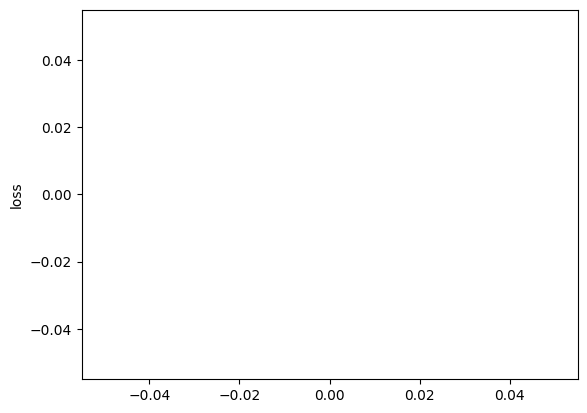

In [ ]:
import datasets

glue_dataset = datasets.load_dataset("glue", "cola")

df = pd.DataFrame()
df['text'] = glue_dataset['train']['sentence']
ddf = dd.from_pandas(df, npartitions=1).compute()

print(ddf)

model = trainer
model.test_data = ddf

predictions = model.test(1)

glue_metric = datasets.load_metric("glue", "cola")
glue_score = glue_metric.compute(predictions=predictions, references=glue_dataset["labels"])

print(glue_score)